In [17]:
import os
import glob
import json
import scipy
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme()
sns.set_context("paper")

import matplotlib.pyplot as plt

### i. Load experiment results from .json files

In [2]:
all_data = []
for path in glob.iglob("./Experiment_Results/*.json"):
    with open(path, 'r') as f:
        jsonobj = json.load(f)
    all_data.append(jsonobj)
print("Number of participants (N): ", len(all_data))

# Ensure all responses are complete
assert all([d["waetresult"]["@state"] == "complete" for d in all_data])

Number of participants (N):  12


### ii. Extract, sort and perform relevant transformations on the .json data

##### Extract top-level reference information

In [3]:
META_DICT  = all_data[0]["waetresult"]
PAGES      = META_DICT["waet"]["page"]
PAGE_0     = PAGES[0]
SCALE_LABS = PAGE_0["interface"]["scales"]["scalelabel"]

STRVALUE_2_INSTR_DICT = {
    obj["@position"]: obj["#text"] for obj in SCALE_LABS
}

INSTR_2_LABEL_DICT = {
    instr: ix for ix, instr in 
        enumerate(STRVALUE_2_INSTR_DICT.values())
}

# Add auxillary keys to the transformation dict,
# to account for the variation in naming schemes
INSTR_2_LABEL_DICT.update({
    "Bass"     : INSTR_2_LABEL_DICT["Double Bass"],
    "PianoLow" : INSTR_2_LABEL_DICT["Piano"],
    "PianoMid" : INSTR_2_LABEL_DICT["Piano"],
    "PianoHigh": INSTR_2_LABEL_DICT["Piano"]
})

INSTR_COUNTS = {
    k: 0 for k in INSTR_2_LABEL_DICT.keys()
}

print(STRVALUE_2_INSTR_DICT)
print(INSTR_2_LABEL_DICT)
print(INSTR_COUNTS)

{'0': 'Piano', '17': 'Double Bass', '34': 'Tuba', '50': 'Viola', '66': 'Oboe', '83': 'Violin', '100': 'Flute'}
{'Piano': 0, 'Double Bass': 1, 'Tuba': 2, 'Viola': 3, 'Oboe': 4, 'Violin': 5, 'Flute': 6, 'Bass': 1, 'PianoLow': 0, 'PianoMid': 0, 'PianoHigh': 0}
{'Piano': 0, 'Double Bass': 0, 'Tuba': 0, 'Viola': 0, 'Oboe': 0, 'Violin': 0, 'Flute': 0, 'Bass': 0, 'PianoLow': 0, 'PianoMid': 0, 'PianoHigh': 0}


##### Construct trial indexers to split results across experimental conditions (articulation, algo)

In [4]:
CONDITION0 = 'NoAlgo'
CONDITION1 = 'CompFreq'
CONDITION2 = 'Reinforced'
INTERACT0 = 'Staccato'
INTERACT1 = 'Legato'
INTERACT2 = 'Mix'

ALGOIX = 0
ARTIIX = 1
INSTIX = 2
algorithm_dict    = {}
articulation_dict = {}

for cur_page in PAGES:
    page_id   = cur_page["@id"]
    elem_info = cur_page["audioelement"]
    audio_id  = elem_info["@id"]
    cond_info = audio_id.split('_')    
    algorithm_dict[page_id]    = cond_info[ALGOIX]
    articulation_dict[page_id] = cond_info[ARTIIX]
    INSTR_COUNTS[cond_info[INSTIX]] += 1
    
algorithm_sr    = pd.Series(data=algorithm_dict   , name="Algorithm")
articulation_sr = pd.Series(data=articulation_dict, name="Articulation")
print(INSTR_COUNTS)

{'Piano': 0, 'Double Bass': 0, 'Tuba': 9, 'Viola': 9, 'Oboe': 9, 'Violin': 9, 'Flute': 9, 'Bass': 9, 'PianoLow': 9, 'PianoMid': 9, 'PianoHigh': 9}


##### Construct a comparison matrix with ground-truth values across all trials 

In [5]:
NTRIALS = len(META_DICT["waet"]["page"])
NINSTR  = len(STRVALUE_2_INSTR_DICT)

COMPARISON_DICT = {}
PAGES = META_DICT["waet"]["page"]
for cur_page in PAGES:
    page_id   = cur_page["@id"]
    elem_info = cur_page["audioelement"]
    audio_id  = elem_info["@id"]
    cur_instr = audio_id.split('_')[INSTIX]
    instr_lab = INSTR_2_LABEL_DICT[cur_instr]
    
    truth_array = [
        1 if i is instr_lab else 0 
            for i in range(NINSTR)
    ]
    
    COMPARISON_DICT[page_id] = truth_array
    
COMPARISON_DF = pd.DataFrame.from_dict(
    COMPARISON_DICT, 
    orient='index', 
    columns=STRVALUE_2_INSTR_DICT.values()
)
COMPARISON_DF

,Piano,Double Bass,Tuba,Viola,Oboe,Violin,Flute
page_0,0,1,0,0,0,0,0
page_1,0,0,0,0,0,0,1
page_2,0,0,0,0,1,0,0
page_3,1,0,0,0,0,0,0
page_4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
page_76,1,0,0,0,0,0,0
page_77,1,0,0,0,0,0,0
page_78,0,0,1,0,0,0,0
page_79,0,0,0,1,0,0,0


### 1.0 Prepare Participants Results

##### 1.1 Setup Helper functions 

In [6]:
def DataFrame_zeros_like(df):
    return df.applymap(lambda x: 0)

def make_guess_dataframe(results_dict):
    # Construct an empty DataFrame with the same index/column...
    # size and labels of `COMPARISON_DF`
    guess_df = DataFrame_zeros_like(COMPARISON_DF)
    
    # Instantiate a list to store trial states
    trial_states = []
    
    # Iterate over every trial and update the empty...
    # DataFrame with the corresponding participants guess
    for trial in results_dict:
        # Extract which trial is referenced
        trial_ref = trial["@ref"]
        
        # Extract completion state
        state = trial["@state"]
        trial_states.append(state == "complete")
        
        # Extract participants response... 
        # (encoded value btw. 0.17 - 1.0)
        response_enc = trial["audioelement"]
        response_enc = float(response_enc["value"])
        response_enc = int(response_enc * 100.)
        response_dec = str(response_enc)
        
        # Get the instrument string label of the response
        instr_label = STRVALUE_2_INSTR_DICT[response_dec]
        
        # Update the correct row/col of the DataFrame
        guess_df.at[trial_ref, instr_label] = 1
        
    # Return the DataFrame for this participant..
    # along with the completion states for each trial
    return guess_df, trial_states

##### 1.2 Compute amount of correct/wrong answers and accumulate into a single DataFrame 

In [7]:
responses = []
responses_instr = []
responses_stats = []

for ix, data_dict in enumerate(all_data):
    data = data_dict["waetresult"]
    data = data["page"]
    
    res, states = make_guess_dataframe(data)
    assert all(states)
    
    match_df = COMPARISON_DF * res
    match_df_agg = match_df.join([algorithm_sr, articulation_sr])
    match_df_agg = match_df_agg.groupby(
        ['Algorithm', 'Articulation']
    ).sum()
    responses_instr.append(match_df_agg)
    responses.append(match_df_agg.sum(axis=1))
    
    analysis_df = match_df.join(algorithm_sr).groupby(
        ['Algorithm']
    ).sum().sum(axis=1)
    
    responses_stats.append(analysis_df)
    
    
agg_responses_df = pd.DataFrame().append(responses).T
agg_responses_instr_df = pd.DataFrame().append(responses_instr)
agg_analysis_df = pd.DataFrame().append(responses_stats)

##### 1.3 Make some pretty plots 

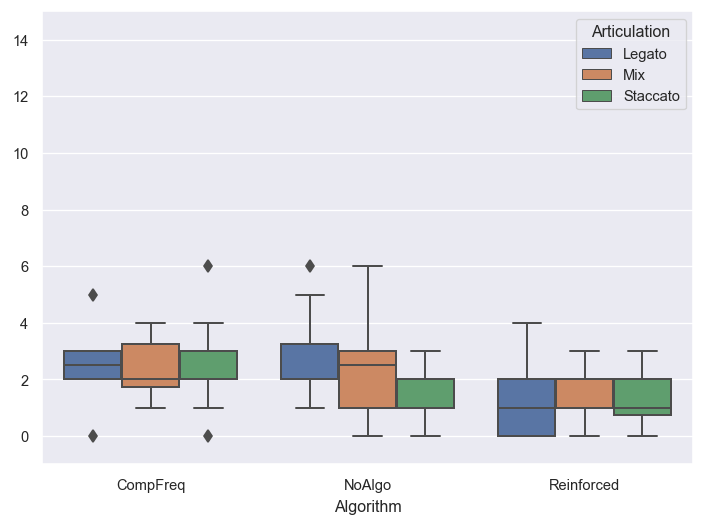

In [30]:
sns_bp_df = agg_responses_df.reset_index().melt(id_vars=[
    'Algorithm', 'Articulation'
], value_name='Amount Correct Responses')

fig, ax = plt.subplots(1, dpi=120, figsize=(7, 5))
bp = sns.boxplot(
    data=sns_bp_df, 
    x='Algorithm', 
    y='Amount Correct Responses', 
    hue='Articulation',
    ax=ax
)
plt.ylim(-1, 15)
ax.set(ylabel=None)
plt.show()

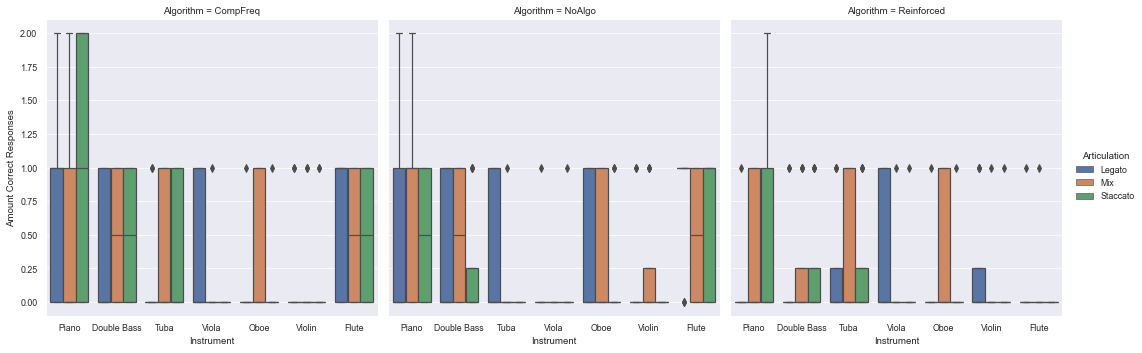

In [9]:
sns_cp_df = agg_responses_instr_df.reset_index().melt(id_vars=[
    'Algorithm', 'Articulation'
], value_name='Amount Correct Responses', var_name='Instrument')


cp = sns.catplot(
    data=sns_cp_df,
    kind="box",
    col='Algorithm',
    y='Amount Correct Responses',
    x='Instrument',
    hue='Articulation',
    #col_wrap=4
)

##### 1.4 Perform statistical tests

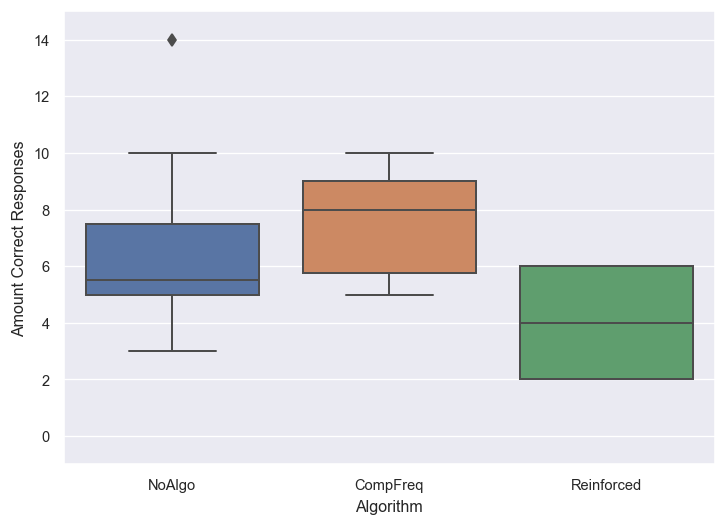

In [31]:
agg_analysis_df_ro = agg_analysis_df[[CONDITION0, CONDITION1, CONDITION2]]

fig, ax = plt.subplots(1, dpi=120, figsize=(7, 5))
bp = sns.boxplot(
    data=agg_analysis_df_ro, 
    ax=ax
)

plt.ylim(-1, 15)
ax.set(ylabel='Amount Correct Responses')
plt.show()

In [22]:
c0 = agg_analysis_df[CONDITION0].to_numpy()
c1 = agg_analysis_df[CONDITION1].to_numpy()
c2 = agg_analysis_df[CONDITION2].to_numpy()
print(c0.shape, c1.shape, c2.shape)

# Compute the medians of each condition
mdn0 = np.median(c0)
mdn1 = np.median(c1)
mdn2 = np.median(c2)
print(mdn0, mdn1, mdn2)

# Friedman "ANOVA"
fm_stat, fm_p = scipy.stats.friedmanchisquare(c0, c1, c2)
print(fm_stat, fm_p)

# Post-hoc Wilcoxon Signed Rank Test
# (Non-parametric equivalent to dependent t-test)

# Check if difference in medians btw NoAlgo and CompFreq
wsr_stat0, wsr_p0 = scipy.stats.wilcoxon(
    x=c1, y=c0,
    alternative='greater',
    mode='approx'
)
# Retrieve z-score from p-value
wsr_z0 = scipy.stats.norm.isf(wsr_p0 / 2)

# Retrieve effect-size from z-score
wsr_r0 = wsr_z0 / np.sqrt(len(c0)*2)
print(wsr_stat0, wsr_p0, wsr_z0, wsr_r0)

# Check if difference in medians btw NoAlgo and Reinforced
wsr_stat1, wsr_p1 = scipy.stats.wilcoxon(
    x=c0, y=c2,
    alternative='greater',
    mode='approx'
)
# Retrieve z-score from p-value
wsr_z1 = scipy.stats.norm.isf(wsr_p1 / 2)

# Retrieve effect-size from z-score
wsr_r1 = wsr_z1 / np.sqrt(len(c0)*2)
print(wsr_stat1, wsr_p1, wsr_z1, wsr_r1)

# Check if difference in medians btw Compfreq and Reinforced
wsr_stat2, wsr_p2 = scipy.stats.wilcoxon(
    x=c1, y=c2,
    alternative='greater',
    mode='approx'
)
# Retrieve z-score from p-value
wsr_z2 = scipy.stats.norm.isf(wsr_p2 / 2)

# Retrieve effect-size from z-score
wsr_r2 = wsr_z2 / np.sqrt(len(c0)*2)
print(wsr_stat2, wsr_p2, wsr_z2, wsr_r2)

(12,) (12,) (12,)
5.5 8.0 4.0
7.644444444444434 0.021879126550464843
43.5 0.1734650786223771 1.361153838434836 0.27784436379967353
52.0 0.04486078435221613 2.005957483574395 0.4094643567062197
64.5 0.002463044857263393 3.0278448771848128 0.6180562474502326


##### 1.5 Secondary Analysis 

In [69]:
grp = agg_responses_df.reset_index().melt(id_vars=[
    'Algorithm', 'Articulation'
], value_name='Amount Correct Responses').groupby(
    ['Algorithm']
)

grp_c0 = grp.get_group(CONDITION0).groupby(
    ['Articulation']
)
grp_c1 = grp.get_group(CONDITION1).groupby(
    ['Articulation']
)
grp_c2 = grp.get_group(CONDITION2).groupby(
    ['Articulation']
)

grps = [grp_c0, grp_c1, grp_c2]
main_conds = [CONDITION0, CONDITION1, CONDITION2]
interacts = [INTERACT0, INTERACT1, INTERACT2]

interact_conditions = []
condition_labels = []

lab = None
for g, i in zip(grps, main_conds):
    for ia in interacts:
        lab = 'G:{0}_IA:{1}'.format(i, ia)
        c_art = g.get_group(ia)
        c_values = c_art["Amount Correct Responses"].to_numpy()
        interact_conditions.append(c_values)
        condition_labels.append(lab)

# Friedman "ANOVA" across all 9 articualtions under every... 
# experimental condition
fm_stat_ia, fm_p_ia = scipy.stats.friedmanchisquare(
    *interact_conditions
)
print(fm_stat_ia, fm_p_ia)


ts = []
res = []
# Multiple compare all interaction conditions
for ct, l0 in zip(interact_conditions, condition_labels):
    for cb, l1 in zip(interact_conditions, condition_labels):
        
        if int(np.sum(np.abs(ct - cb))) == 0:
            continue
        
        t, p = scipy.stats.wilcoxon(x=ct, y=cb,
            #alternative='greater',
            mode='approx'
        )
        
        if p > (0.05):
            continue
        
        # Retrieve z-score from p-value
        z = scipy.stats.norm.isf(p / 2)

        # Retrieve effect-size from z-score
        r = z / np.sqrt(len(ct)*2)
        ls = "Comparing {0} and {1}".format(l0, l1)
        res.append((ls, t, p, z, r))
        ts.append(t)

_, idx = np.unique(ts, return_index=True)
for i in idx:
    l = res[i][0]
    
    if CONDITION2 in l:
        continue
    
    print(l)
    print(*res[i][1:])

# No Algo Staccato
mdn0 = np.median(interact_conditions[5])

# No Algo Legato
mdn1 = np.median(interact_conditions[3])

# CompFreq Staccato
mdn2 = np.median(interact_conditions[2])
print(mdn0, mdn1, mdn2)

16.6215384615385 0.03430030999850965
Comparing G:NoAlgo_IA:Staccato and G:CompFreq_IA:Staccato
0.0 0.004957885081270752 2.8097574347450824 0.5735393346764046
Comparing G:NoAlgo_IA:Staccato and G:NoAlgo_IA:Legato
5.5 0.04143161833669888 2.0391844892738282 0.416246790843233
2.0 3.0 2.5
